# 3. Overfitting and underfitting
[*This is part 3 of a 6-part tutorial on machine learning in scikit-learn.*]

We ended the last section observing that, as we increased the number of features used to generate our age predictions, our model's performance also increased. We noted that this was potentially concerning, because the model was performing *so well* that there was simply no way the estimates we were getting could be accurate: the model's performance was too good to be true. I suggested that the model was *overfitting* the data, but didn't really explain what that meant. In this section, we'll delve into overfitting in detail.

Let's start by importing all the stuff we've seen before (we'll introduce new tools as we meet them):

In [1]:
# our core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn stuff we've already encountered
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

To get a basic understanding of the phenomenon of overfitting, let's set aside our relatively complex neuroimaging dataset for the moment and work with some simple bivariate examples.

Let's start by sampling some data from a noisy function where the underlying functional form is quadratic.

In [2]:
# we wrap the data generation code in a function so we can call
# it again later.
def make_xy(n, sd=0.5):
    ''' Generate x and y variables from a fixed quadratic function,
    adding noise. '''
    x = np.random.normal(size=n)
    y = (0.7 * x) ** 2 + 0.1 * x + np.random.normal(10, sd, size=n)
    return x, y

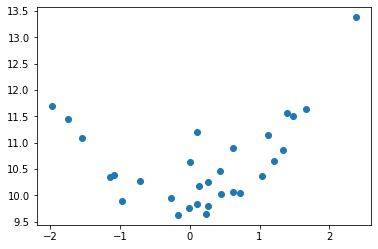

In [3]:
# fix the random number generator so we get reproducible results
np.random.seed(10)

x, y = make_xy(30)
plt.scatter(x, y);

Suppose we try to fit these data with a linear model...

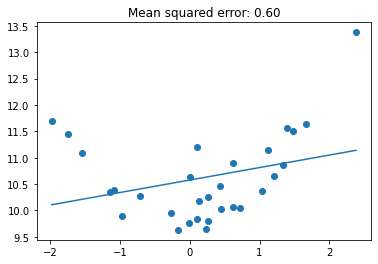

In [4]:
est = LinearRegression()
est.fit(x[:, None], y)

x_range = np.linspace(x.min(), x.max(), 100)
reg_line = est.predict(x_range[:, None])

plt.scatter(x, y)
plt.plot(x_range, reg_line);
mse = mean_squared_error(y, est.predict(x[:, None]))
plt.title(f"Mean squared error: {mse:.2f}");

The fit looks... meh. It seems pretty clear that our linear regression model is *underfitting* the data—meaning, there are clear patterns in the data that the fitted model fails to describe.

What can we do about this? Well, the problem here is that our model is insufficiently flexible; our straight regression line can't bend itself to fit the contours of the observed data. Clearly, the solution is to use a more flexible estimator! A linear fit won't cut it—we need to fit *curves*.

Just to make sure we don't underfit again, let's use a *really* flexible estimator—specifically, 10th degree polynomial regression.

This is also a good opportunity to introduce a helpful class in scikit-learn called a `Pipeline`. The idea behind a `Pipeline` is that we can stack arbitrarily many transformation steps together in a sequence, and then cap them off with an estimator of our choice. The whole pipeline will then behave like a single estimator—i.e., we only need to call `fit()` and `predict()` once.

Using a pipeline will allow us to introduce a preprocessing step before the `LinearRegression` model receives our data, in which we create a bunch of polynomial features (by taking `x**2`, `x**3`, `x**4`, and so on—all the way up to `x**10`). We'll make use of scikit-learn's handy `PolynomialFeatures` transformer, which can be found in the [`preprocessing` module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) (there are all kinds of other useful data preprocessing tools in there).

Here's the result of our second model-fitting exercise:

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# wrap the pipeline creation process in a function, so we can
# conveniently parameterize the degree of the polynomial.
def make_pipeline(degree=1): 
    # Polynomial regression is just linear regression with polynomial
    # features, so we can use scikit-learn's PolyNomialFeatures helper
    # to generate an expanded design matrix as an extra pipeline step
    # before model estimation.
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Construct an sklearn Pipeline, which behaves like a single Estimator.
    pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", LinearRegression())
    ])
    return pipeline

Now we can initialize a pipeline with `degree=10`, and fit it to our toy data:

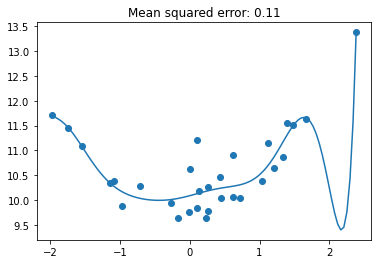

In [6]:
# play with this!
DEGREE = 10

pipeline = make_pipeline(DEGREE)

pipeline.fit(x[:, None], y)
reg_line = pipeline.predict(x_range[:, None])

plt.scatter(x, y)
plt.plot(x_range, reg_line)
mse = mean_squared_error(y, pipeline.predict(x[:, None]))
plt.title(f"Mean squared error: {mse:.2f}");

On paper, this model fits the data much better than the first model, in the sense that it reduces the mean squared error relative to the simpler linear model. But, much as it seemed clear that the previous model was underfitting, it should now be intuitively obvious to you that the 10th-degree polynomial model is *overfitting*. That is, the line of best fit bends in some fairly unnatural ways in order to capture individual data points. While this helps reduce the error in *these* particular data, it's hard to imagine that the same line would still be very close to the data if we sampled from the same distribution a second or third time.

We can test this intuition by doing exactly that: we sample some more data from the same process, and see how well our fitted model predicts the new scores.

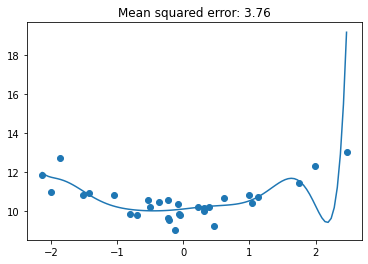

In [7]:
test_x, test_y = make_xy(30)

plt.scatter(test_x, test_y)

# Update the x range
x_range = np.linspace(test_x.min(), test_x.max(), 100)
reg_line = pipeline.predict(x_range[:, None])
plt.plot(x_range, reg_line)

mse = mean_squared_error(y, pipeline.predict(test_x[:, None]))
plt.title(f"Mean squared error: {mse:.2f}");

That's... not so good. We can see that the fitted model generates wildly off-base predictions for new observations outside its original training range (though, if we zoomed in, we'd find that it's not so hot for observations within the original range either).

Of course, since we created the data-generating process ourselves, and know the ground truth in this case, we may as well go ahead and fit the data with the correct functional form, which i this case is a polynomial with degree 2:

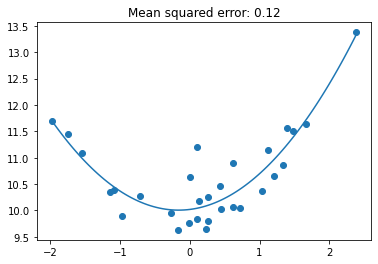

In [8]:
# Call our pipeline-generation function
pipeline = make_pipeline(2)

# Fit to the training data
pipeline.fit(x[:, None], y)

# Predict values for range of x
x_range = np.linspace(x.min(), x.max(), 100)
reg_line = pipeline.predict(x_range[:, None])

# Plot
plt.scatter(x, y)
plt.plot(x_range, reg_line)
mse = mean_squared_error(y, pipeline.predict(x[:, None]))
plt.title(f"Mean squared error: {mse:.2f}");

There, that looks much better.

Of course, in the real world, we don't know the ground truth (if we did, we wouldn't need to fit a model in the first place!). So we'd have to navigate between the two extremes of overfitting and underfitting in some other way. Finding this delicate balance is one of the central problems of machine learning—perhaps *the* central problem. For any given dataset, a more flexible model will be able to capture more nuanced, subtle patterns in the data. The cost of flexibility, however, is that such a model is also more likely to hallucinate—i.e., to fit patterns in the data that are only there because of noise, and won't generalize to new samples. Conversely, a less flexible model is only capable of fitting simple patterns in the data. This means it will avoid chasing down rabbit holes full of spurious patterns; but it does so at the cost of missing out on a lot of *real* patterns.

One way to think about this is that, as an analyst, the choice you face is almost never between *good* models and *bad* models, but rather, between lazy and energetic ones (later on, we'll also see that there are many different ways to be lazy or energetic). In the above example, the straight line is a lazy model: it has only one degree of freedom to play with, and if it can't fit the data well with that one degree of variation, it doesn't care. It'll just sigh and go back to the couch to watch tv.

The 10th-degree polynomial, by contrast, is hyperactive and prone to conspiracy theories: it sees patterns *everywhere*, and is very interested in convincing you that all of the conspiracies are real.

Getting it right in any given situation requires you to strike a balance between these two extremes. Unfortunately, the precise point of optimality varies on a case-by-case basis, so there is, as they say in machine learning, [no free lunch](https://en.wikipedia.org/wiki/No_free_lunch_theorem).

Later on, we'll connect the ideas of overfitting vs. underfitting (or, relatedly, flexibility vs. stability) to another key concept—the *bias-variance tradeoff*. For now though, let's hone our intuitions about overfitting and underfitting by interactively playing with our polynomial regression model a bit more.

In [9]:
# provides interactive widget support
from ipywidgets import interact


def plot_fit(n=30, sd=0.5, degree=1, seed=500, show_fit=True):
    np.random.seed(seed)

    x, y = make_xy(n, sd)
    x_test, y_test = make_xy(n, sd)

    pipeline = make_pipeline(degree)
    pipeline.fit(x[:, None], y)
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
    axes[0].scatter(x, y)
    all_x = np.r_[x, x_test]
    x_range = np.linspace(all_x.min(), all_x.max(), 100)
    mse = mean_squared_error(y, pipeline.predict(x[:, None]))
    axes[0].set_title(f"Training sample (MSE = {mse:.2f})", fontsize=16);

    axes[1].scatter(x_test, y_test, color='g')
    mse = mean_squared_error(y_test,pipeline.predict(x_test[:, None]))
    axes[1].set_title(f"Test sample (MSE = {mse:.2f})", fontsize=16);
    
    if show_fit:
        reg_line = pipeline.predict(x_range[:, None])
        axes[0].plot(x_range, reg_line)
        axes[1].plot(x_range, reg_line, 'g')

# uncomment next line for static version
# plot_fit(degree=10)

interact(plot_fit, n=(10, 500, 10), sd=(0, 5, 0.1), degree=(1, 20), seed=(1, 1000, 1), show_fit=True);

interactive(children=(IntSlider(value=30, description='n', max=500, min=10, step=10), FloatSlider(value=0.5, d…